In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Function to create LSTM dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Function to build and compile an LSTM model
def build_lstm_model(time_step):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
# Step 2: Prepare the data
# Now we will preprocess the four datasets and normalize them using MinMaxScaler.

# Load datasets
data1 = pd.read_csv('texas_110924.csv')
data2 = pd.read_csv('texas_130924.csv')
data3 = pd.read_csv('texas_120924.csv')
data4 = pd.read_csv('texas_80924.csv')

# Data preparation function to preprocess data (same steps for all datasets)
def preprocess_data(df):
    df['DATE'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format='%m/%d/%Y')
    df['CST'] = pd.to_datetime(df['CST'], format='%H:%M').dt.time
    df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['DATE'], row['CST']), axis=1)
    df.set_index('Datetime', inplace=True)
    df = df[['Global Horizontal [W/m^2]']].dropna()
    return df

# Preprocess all datasets
df1 = preprocess_data(data1)
df2 = preprocess_data(data2)
df3 = preprocess_data(data3)
df4 = preprocess_data(data4)

# Normalize the data using MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 5))  # Use (0,2) for spike curves

# scaler = MinMaxScaler(feature_range=(0, 2))  # Use (0,2) for flat curves

scaler = MinMaxScaler(feature_range=(0, 10))  # Use (0,2) for flat curves

scaled_data1 = scaler.fit_transform(df1.values)
scaled_data2 = scaler.fit_transform(df2.values)
scaled_data3 = scaler.fit_transform(df3.values)
scaled_data4 = scaler.transform(df4.values)  # We only transform data4 since we already fitted the scaler

# Step 3: Create and train models on each dataset
# For each dataset (data1, data2, and data3), we will create an LSTM model, train it, and store the trained models.

time_step = 30  # or another suitable value
models = []

# Train model on data1
X1, y1 = create_dataset(scaled_data1, time_step)
X1 = X1.reshape(X1.shape[0], X1.shape[1], 1)
model1 = build_lstm_model(time_step)
history1 = model1.fit(X1, y1, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model1)

# Train model on data2
X2, y2 = create_dataset(scaled_data2, time_step)
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)
model2 = build_lstm_model(time_step)
history2 = model2.fit(X2, y2, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model2)

# Train model on data3
X3, y3 = create_dataset(scaled_data3, time_step)
X3 = X3.reshape(X3.shape[0], X3.shape[1], 1)
model3 = build_lstm_model(time_step)
history3 = model3.fit(X3, y3, epochs=100, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10)])
models.append(model3)


Epoch 1/100
45/45 [==============================] - 12s 96ms/step - loss: 1.4836
Epoch 2/100
45/45 [==============================] - 4s 96ms/step - loss: 0.7713
Epoch 3/100
45/45 [==============================] - 4s 99ms/step - loss: 0.6781
Epoch 4/100
45/45 [==============================] - 4s 82ms/step - loss: 0.6090
Epoch 5/100
45/45 [==============================] - 4s 96ms/step - loss: 0.5519
Epoch 6/100
45/45 [==============================] - 4s 96ms/step - loss: 0.4875
Epoch 7/100
45/45 [==============================] - 4s 98ms/step - loss: 0.4635
Epoch 8/100
45/45 [==============================] - 4s 99ms/step - loss: 0.3995
Epoch 23/100
45/45 [==============================] - 4s 86ms/step - loss: 0.4286
Epoch 24/100
45/45 [==============================] - 4s 87ms/step - loss: 0.4159
Epoch 25/100
45/45 [==============================] - 5s 107ms/step - loss: 0.4082
Epoch 26/100
45/45 [==============================] - 4s 87ms/step - loss: 0.3656
Epoch 27/100
45/45 [==

45/45 [==============================] - 4s 40ms/step


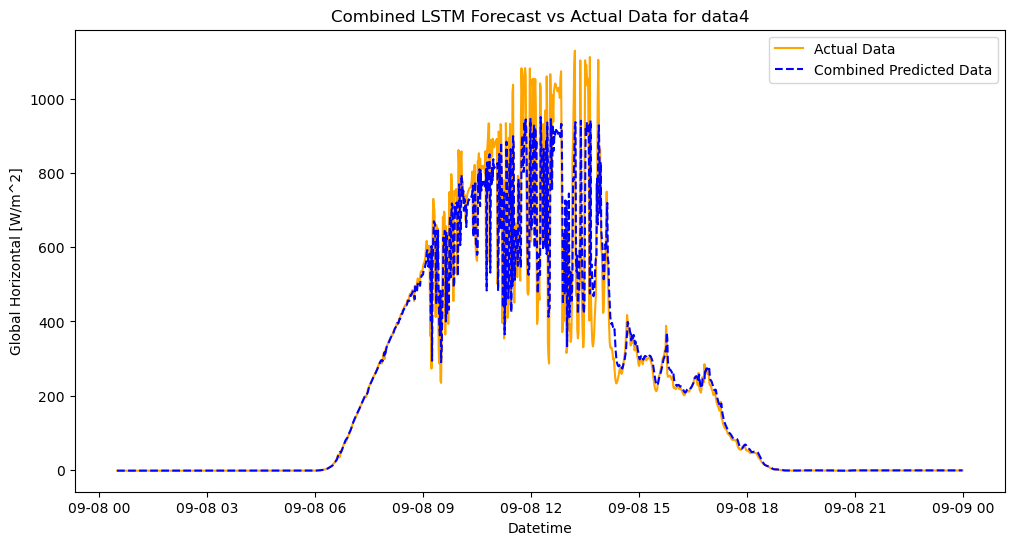

In [5]:
# Step 4: Forecast for data4 using each model and combine predictions
# After training the models, we will use each model to predict the values for data4. Finally, we will combine the predictions from all models (e.g., using averaging).

# Prepare dataset for forecasting (data4)
X4, y4 = create_dataset(scaled_data4, time_step)
X4 = X4.reshape(X4.shape[0], X4.shape[1], 1)

# Predict the test set results for data4 using each model
predictions = []

for model in models:
    pred = model.predict(X4)
    predictions.append(pred)

# Combine predictions from all models (e.g., using averaging)
predictions = np.array(predictions)  # Shape: (n_models, n_samples, 1)
combined_predictions = np.mean(predictions, axis=0)  # Averaging the predictions across models

# Rescale the predictions back to the original scale
combined_predictions_rescaled = scaler.inverse_transform(combined_predictions)
y4_rescaled = scaler.inverse_transform(y4.reshape(-1, 1))

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df4.index[time_step:], y4_rescaled, color='orange', label='Actual Data')
plt.plot(df4.index[time_step:], combined_predictions_rescaled, color='blue', linestyle='--', label='Combined Predicted Data')
plt.title('Combined LSTM Forecast vs Actual Data for data4')
plt.xlabel('Datetime')
plt.ylabel('Global Horizontal [W/m^2]')
plt.legend()
plt.show()


45/45 [==============================] - 2s 35ms/step


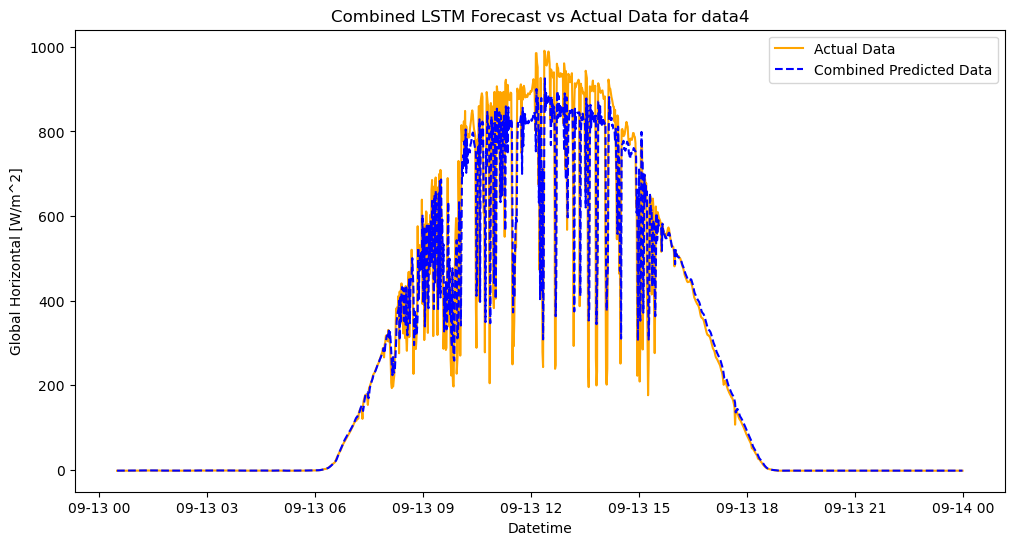

In [6]:
# data4 = pd.read_csv('texas.csv')
# data4 = pd.read_csv('texas_150924.csv')
# data4 = pd.read_csv('texas_110924.csv')
# data4 = pd.read_csv('texas_120924.csv')
data4 = pd.read_csv('texas_130924.csv')
# data4 = pd.read_csv('texas_70924.csv')
# data4 = pd.read_csv('texas_60924.csv')
# data4 = pd.read_csv('texas_50924.csv')
# data4 = pd.read_csv('texas_40924.csv')
# data4 = pd.read_csv('texas_30924.csv')
# data4 = pd.read_csv('texas_20924.csv')
# data4 = pd.read_csv('texas_10924.csv')
# data4 = pd.read_csv('texas_310824.csv')
# data4 = pd.read_csv('texas_300824.csv')

df4 = preprocess_data(data4)
scaled_data4 = scaler.transform(df4.values)  # We only transform data4 since we already fitted the scaler


# Prepare dataset for forecasting (data4)
X4, y4 = create_dataset(scaled_data4, time_step)
X4 = X4.reshape(X4.shape[0], X4.shape[1], 1)

# Predict the test set results for data4 using each model
predictions = []

for model in models:
    pred = model.predict(X4)
    predictions.append(pred)

# Combine predictions from all models (e.g., using averaging)
predictions = np.array(predictions)  # Shape: (n_models, n_samples, 1)
combined_predictions = np.mean(predictions, axis=0)  # Averaging the predictions across models

# Rescale the predictions back to the original scale
combined_predictions_rescaled = scaler.inverse_transform(combined_predictions)
y4_rescaled = scaler.inverse_transform(y4.reshape(-1, 1))

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df4.index[time_step:], y4_rescaled, color='orange', label='Actual Data')
plt.plot(df4.index[time_step:], combined_predictions_rescaled, color='blue', linestyle='--', label='Combined Predicted Data')
plt.title('Combined LSTM Forecast vs Actual Data for data4')
plt.xlabel('Datetime')
plt.ylabel('Global Horizontal [W/m^2]')
plt.legend()
plt.show()